# Projet optimisation de la trajectoire d'un robot

# Partie 1

### Question 1

Les inconnues du problème sont les poses $Pi$ de la trajectoire. On pose $P_{i}=(x_{i},y_{i},\theta_{i})$ avec $x_i,y_i,\theta_i$ définis pour $i$ allant de $0$ à $n$ par rapport à un repère fixe ayant pour origine $P_0 = (0,0,0)$.

On cherche à les déterminer grâce aux relations d'odométrie et de fermeture de boucles qui elles sont connues.


### Question 2

Chaque relation d'odométrie est donnée relativement à la pose précédente. 
On a donc les relations suivantes pour l'odométrie : 

$$
\left\{
    \begin{array}{ll}
        x_{i+1} = x_i + dx_i\cos{\theta_i}- dy_i\sin{}\theta_i = f_{x}(x_{i},dx_{i},dy_{i},\theta_{i})\\
        y_{i+1} = y_i + dx_i\sin{\theta_i}+ dy_i\cos{}\theta_i = f_{y}(y_{i},dx_{i},dy_{i},\theta_{i})\\
        \theta_{i+1} = \theta_i + d\theta_i = f_{\theta}(\theta_{i},d\theta_{i})
    \end{array}
\right.
$$

Et on adapte pour les relations de fermetures de boucle en remplaçant $i+1$ par $j$ avec $j$ l'indice de la fermeture de boucle. 

### Question 3

On veut ici déterminer quelle fonction minimiser afin de vérifier au mieux les données d'odométrie et de fermetures de boucles. On va d'abord introduire plusieurs notations.

On va travailler ici avec des fonctions $f_{x}, f_{y} et f_{\theta}$ définies respectivement par les relations données en question 2 s'appliquant sur les variables $x_{i}, y_{i}$ et $\theta_{i}$. De plus, les éléments que nous appelerons $dx_{i},dy_{i}$ et $d\theta_{i}$ ainsi que $dx'_{i},dy'_{i}$ et $d\theta'_{i}$ dans la suite correspondent respectivement aux valeurs d'odométrie et de fermeture de boucles mesurées par le robot lors de son parcours, et sont donc connues et fixées.

Ce faisant, on note $P_{i}=(x_{i},y_{i},\theta_{i})$ un triplet de $R^{3}$ et M le vecteur de dimension 3n définit par $M=(P_{i})_{1 \leqslant i \leqslant n}$. 

Si M est un minimum de notre fonction, on veut que chacun des $p_{i}$ vérifie au mieux les relations d'odométrie et de fermetures de boucles, c'est-à-dire:

1) $\forall i \in {1,...,n}$,
$x_{i+1}\approx f_{x}(x_{i},dx_{i},dy_{i},\theta_{i})$,
$y_{i+1}\approx f_{y}(y_{i},dx_{i},dy_{i},\theta_{i})$,
$\theta_{i+1}\approx f_{\theta}(\theta_{i},d\theta_{i})$.

2) Si l'on note B l'ensemble des couples (j,i) correspondant à des fermetures de boucles détectées par le robot, on veut également vérifier: $x_{j}\approx f_{x}(x_{i},dx'_{i},dy'_{i},\theta_{i})$, 
$y_{j}\approx f_{y}(y_{i},dx'_{i},dy'_{i},\theta_{i})$ et
$\theta_{j}\approx f_{\theta}(\theta_{i},d\theta'_{i})$.

Plus concrètement, ces approximations se traduisent par le fait que les quantités $\left|x_{i+1}- f_{x}(x_{i},dx_{i},dy_{i},\theta_{i}) \right|^{2}$ soient le plus petites possibles, de même en remplaçant les $x$ par les $y$ et les $\theta$, et de même pour les relations de fermeture de boucle.

Comme on veut que cela soit vrai pour toutes ces relations, et que celles-ci sont interdépendantes, cela revient à minimiser la fonction de $R^{3n}$ suivante:

 $M \in R^{3n} \rightarrow \sum_{i=1}^{n} \left\|P_{i+1} - F(P_{i},dx_{i},dy_{i},d\theta_{i}) \right\|^{2} + \sum_{(j,i) \in B} \left\|P_{j} - F(P_{i},dx'_{i},dy'_{i},d\theta'_{i}) \right\|^{2}$ 

où les $P_{i}$ ont été définis ci-dessus comme les triplets composants de M et où $F(P_{i},dx_{i},dy_{i},d\theta_{i})=(f_{x}(x_{i},dx_{i},dy_{i},\theta_{i}),f_{y}(y_{i},dx_{i},dy_{i},\theta_{i}),f_{\theta}(\theta_{i},d\theta_{i}))$. 

# Partie 2

In [29]:
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd
import copy
import scipy.optimize
from math import cos, sin, pi, sqrt

### Question 1

In [42]:
donnees_odo = []
donnees_loop = []

def recup_donnees(fichier):
    with open(fichier, 'r') as intel:
        for ligne in intel:
            l = ligne.split()
            for i in range(1,len(l)):
                l[i]=float(l[i])
            if l[0]=="EDGE_ODO":
                donnees_odo.append(l[1:3]+[l[3:]])
            else:
                donnees_loop.append(l[1:3]+[l[3:]])
                
recup_donnees("INTEL.txt")
donnees_loop


[[19.0, 166.0, [-2.459689, 0.241111, 0.2528]],
 [19.0, 172.0, [1.067903, 0.915786, 0.14947]],
 [25.0, 172.0, [-2.539634, 0.85263, -0.02986]],
 [25.0, 178.0, [1.225223, 0.672079, -0.10248]],
 [32.0, 178.0, [-2.020007, -0.239771, 0.71518]],
 [32.0, 183.0, [-0.092559, 0.424181, 0.0416]],
 [44.0, 189.0, [-2.265706, -0.570857, 0.19772]],
 [44.0, 195.0, [1.302289, -0.133004, -0.00528]],
 [50.0, 195.0, [-2.374379, -0.253682, 0.21612]],
 [50.0, 201.0, [1.291572, 0.086248, -0.0507]],
 [50.0, 203.0, [2.550695, 0.035722, -0.08465]],
 [61.0, 203.0, [-2.852494, 0.122053, 0.07787]],
 [61.0, 209.0, [0.73078, 0.07297, 0.00889]],
 [67.0, 209.0, [-2.822142, 0.138051, -0.00446]],
 [67.0, 220.0, [0.783704, -1.176736, -1.4129]],
 [81.0, 220.0, [-0.868391, -0.009825, -0.04688]],
 [81.0, 226.0, [2.836453, 0.058719, 0.04915]],
 [87.0, 226.0, [-0.45964, 0.184679, 0.34383]],
 [87.0, 231.0, [1.060624, 0.863823, 0.29401]],
 [94.0, 231.0, [-2.231597, 0.316386, 0.18025]],
 [94.0, 241.0, [2.816677, 0.483252, 0.0414]

### Question 2

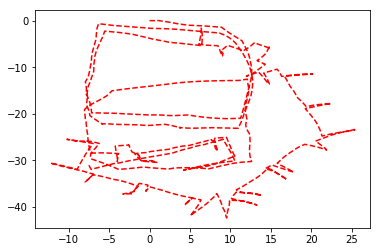

In [11]:
def estim_trajectoire(odometrie):
    liste_x = [0]
    liste_y = [0]
    liste_theta = [0]
    for i in range(len(odometrie)):
        p_i = np.array([liste_x[-1], liste_y[-1], liste_theta[-1]])
        di = np.array(odometrie[i][2])
        rot = np.array([[cos(p_i[2]), -sin(p_i[2]), 0], [sin(p_i[2]),cos(p_i[2]), 0], [0, 0, 1]])
        p_i = p_i + np.dot(rot, di)
        liste_x.append(p_i[0])
        liste_y.append(p_i[1])
        liste_theta.append(p_i[2])
    return liste_x, liste_y, liste_theta

x, y, t = estim_trajectoire(donnees_odo)
plt.figure()
plt.plot(x, y, 'r--')
plt.show()
        


### Question 3

#### Convexité de la fonction

Interessons nous d'abord à la convexité de la fonction. Comme celle-ci contient des cosinus et sinus en fonction des variables $\theta$ de chaque pose, on sent que la fonction ne sera pas convexe. Un moyen de vérifier qu'elle ne l'est pas est de faire varier simplement le $\theta$ d'une seule pose et de tracer l'allure de la courbe que l'on obtient.

In [56]:
#Definition de la fonction à minimiser f_minim en trois étapes

def F(p_i,di):
    rot = np.array([[np.cos(p_i[2]), -np.sin(p_i[2]), 0], [np.sin(p_i[2]),np.cos(p_i[2]), 0], [0, 0, 1]])
    p_i = p_i + np.dot(rot, np.array(di))
    return p_i
    
def norme(X):
    return np.sqrt(sum(X[i]**2 for i in range(len(X))))
    
def f_minim_pose(P,i):
    """C'est la fonction qui calcule les termes de la somme où intervient uniquement la pose Pi"""
    
    #Partie odométrie
    p_i=np.array(P[i])
    pi_1=np.array(P[i+1])
    relations_odo=[]
    if i<len(donnees_odo):
        relations_odo = donnees_odo[i]
    diff_o=pi_1-F(p_i,np.array(relations_odo[2]))
    a=(norme(diff_o))

    #Partie loop
    relations_loop = [relation for relation in donnees_loop if relation[0]==i] #Pas les relations où i est le deuxième indice pour ne pas compter les relations 2 fois
    indexes_loop = [int(relation[1]) for relation in relations_loop]
    Pj=[np.array(P[j]) for j in indexes_loop] #Les poses qui ont des relations de fermeture de boucle avec la pose Pi
    for k in range(len(relations_loop)):
        diff=Pj[k]-F(p_i,np.array(relations_loop[k][2]))
        a+=(norme(diff))
    return a

def f_minim(P):
    P=np.array([[P[3*i],P[3*i+1],P[3*i+2]] for i in range(int(len(P)/3))]) #On passe le vectur en version matricielle [[x1,y1,theta1],...,[xn,yn,thetan]] pour utiliser la fonction précédente
    return sum([f_minim_pose(P,i) for i in range(len(donnees_odo))])


#Vecteur de R^3n correspondant à l'estimation précédente
P=[]
for i in range(len(x)):
    P.append(x[i])
    P.append(y[i])
    P.append(t[i])
P=np.array(P)
    
#Variation de theta de la pose k
k=19
print(f_minim(P))
print(np.linalg.norm(P))
print(norme(P))

"""liste_theta=np.linspace(-3*pi,3*pi,300)
liste_f=[]
for i in range(300):
    P[3*k+2]=liste_theta[i]
    liste_f.append(f_minim(P))
    
plt.figure()
plt.plot(liste_theta, liste_f, 'b--')
plt.title("Fonction à minimiser")


plt.show()"""

609595.6753715187
1770.1931478963636
1770.1931478963618


'liste_theta=np.linspace(-3*pi,3*pi,300)\nliste_f=[]\nfor i in range(300):\n    P[3*k+2]=liste_theta[i]\n    liste_f.append(f_minim(P))\n    \nplt.figure()\nplt.plot(liste_theta, liste_f, \'b--\')\nplt.title("Fonction à minimiser")\n\n\nplt.show()'

On voit donc que la fonction n'est pas convexe. 

#### Existence et unicité de la solution

De plus, sur cet exemple, on a un minimum atteint pour deux valeurs de $\theta$ différentes, ce qui peut supposer qu'il soit possible d'obtenir le même résultat pour un vecteur P qui minimise la fonction. Si ce n'est pas le cas pour tout jeu de données d'entrée (s'il n'y a que des relations d'odométrie, il y'a unicité de la solution par exemple), on peut trouver des jeux de données qui ont plusieurs solutions. Pour plus de détails, des démonstrations moins qualitatives sont en pièce jointe.

L'existence de la solution se justifie par le caractère fermé borné de l'espace dans lequel on cherche nos solutions, qui n'est pas $R^{3n}$ tout entier mais restreint par les dimensions du laboratoire selon x et y. Pour les theta, l'espace dans lequel on les cherche est au plus [0,2n$\pi]^{n}$ car tous les d$\theta$ appartiennent à [0,2$\pi$].

#### Conditionnement

Calculons désormais le conditionnement du problème, c'est-à-dire la sensibilité relative de la fonction f par rapport à une légère variation spatiale du point en laquelle on l'évalue. On va donc calculer $\frac{\|f(x)-f(x+\delta)\|}{\|f(x)_\| \epsilon}$


In [54]:
epsilon=10**(-16)
m=10
n=3*(len(donnees_odo)+1)

def conditionnement(f,liste,epsilon,deplacement):
    l=[]
    for x in liste:
        k=abs((f(np.array(x)+np.array(deplacement))-f(x))/f(x))*1/epsilon
        l.append(k)
    return l

def normalise(x):
    norm=norme(np.array(x))
    n=len(x)
    for i in range(n):
        x[i]=x[i]/norm
    return x

from random import uniform

#on crée des vecteurs de façon aléatoire de norme variant de 1 à 100 afin de déterminer la valeur de k et se cantonner à un espace borné, comme le laboratoire
liste=[normalise([uniform(-i,i) for k in range(n)]) for i in range (1,100)]
p=len(liste)
for i in range(p):
    for j in range(n):
        liste[i][j]=liste[i][j]*(i+1)


#print([[f_minim(vecteur+deplacement),f_minim(vecteur)] for vecteur in liste])


deplacement=[uniform(-1,1)*epsilon for k in range(n)] #on crée un déplacement de façon aléatoire et plus petit que $\espilon$ en valeur absolue pour chaque composante

"""X=liste[0]
print(np.array(deplacement))
print(np.array(X))
print(np.array(liste[0])+np.array(deplacement))
"""

l=conditionnement(f_minim,liste,epsilon,deplacement)
print(l)

k=sum(l)/len(l)
print("Moyenne:", k)

[0.0, 2.0174939352065415, 1.995677360691019, 0.0, 1.977513831904391, 0.0, 0.0, 0.0, 1.8841190237046601, 1.8145120984205507, 1.8075903234446793, 1.7338961271337312, 0.0, 1.6744667083559757, 0.0, 1.5903038740027753, 0.0, 0.0, 0.0, 1.3936014095864393, 0.0, 1.33610144672469, 0.0, 0.0, 1.2245931871847677, 0.0, 1.1413085858426282, 0.0, 0.0, 0.0, 0.0, 1.9284012396165422, 3.6783687034876773, 0.0, 0.0, 1.6960068091448712, 0.0, 1.5755796344613457, 0.0, 2.9261148856045285, 0.0, 1.4061579192725593, 0.0, 0.0, 3.822956037048563, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.75882117195266, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4484115420005113, 0.0, 1.3948233200107103, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.144748675554602, 2.1308949313611003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5897143907471245, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Moyenne: 0.495880577499653


Même si la valeur de k est relativement faible (moyenne inférieure à 1) elle reste très grande devant epsilon ce qui indique un mauvais conditionnement du problème.


La valeur de k obtenue est faible devant $\epsilon$, ce qui signifie que le problème est bien conditionné. On sait de plus que la fonction f diverge quand $\|M\|$, $M \in R^{3n}$ diverge. Ainsi, si f(y) est plutôt proche de f(x), cela signifie que x et y ne sont pas trop éloignés spatialement l'un de l'autre.
Et, bien que l'on ne prenne pas en compte les données de fermeture de boucle, on peut considérer que le vecteur calculé en question 2 de cette deuxième partie est une première approximation (bien que grossière) du vecteur solution. Ainsi, il n'est pas trop éloigné spatialement du vecteur x* solution.
Comme il s'agit d'un problème d'optimisation non-convexe, lorsque l'on a atteint un minimum local (gradient nul), on ne peut savoir qu'il est global uniquement si l'on a testé toutes les autres valeurs, ce qui est très coûteux.
Mais, si l'on sait qu'une racine n'est pas trop éloignée spatialement du minimum global, on peut en utilisant des méthodes d'optimisation pour des fonctions convexes, espérer converger vers ce minimum global.
C'est ce choix que nous avons fait pour la question suivante.

### Question 4

Même si la fonction n'est pas convexe, les oscillations très légères comparées au caractère quadratique de la fonction nous permettent de penser qu'une méthode de descente de gradient à pas variable avec conditions de Wolfe ne nous mènera au minimum global. On part de l'estimation avec les relations d'odométrie seulement.

In [57]:
#On définit le gradient
def grad_f_minim(p) : 
    gradf = autograd.grad(f_minim)
    gradient = gradf(p)
    return gradient

print(P)
print(grad_f_minim(P))

# Conditions de Wolfe
def wolfe_step(fun, grad_fun, xk, pk, c1 = 0.25, c2 = 0.75, M = 1000):
    l_moins = 0
    l_plus = 0
    f_xk = fun(xk)
    grad_f_xk = grad_fun(xk)
    li = 1 #- 2*0.1*abs(f_x) / np.dot(grad_f_x,d)
    i = 0
    while(i < M):
        if (fun(xk+li*pk)>(f_xk+c1*li*np.dot(grad_f_xk,pk))):
            l_plus = li
            li = (l_moins+l_plus)/2.0
        else:
            if (np.dot(grad_fun(xk+li*pk),pk) < c2*np.dot(grad_f_xk,pk)):
                l_moins = li
                if (l_plus == 0):
                    li = 2*li
                else:
                    li = (l_moins+l_plus)/2.0
            else:
                return li
        i = i + 1
    return li

def optim_gradient_wolfe_step(fun, grad_fun, x0, max_iter = 100000, epsilon_grad_fun = 1e-8):
    k = 0
    xk = x0
    grad_f_xk = grad_fun(xk)
    while ((k<max_iter) and (norme(grad_f_xk)>epsilon_grad_fun)):
        pk = -grad_f_xk
        lk = wolfe_step(fun, grad_fun, xk, pk)
        xk = xk + lk*pk
        grad_f_xk = grad_fun(xk)
        k = k + 1
    print("Nombre d'iterations : ", k)
    return xk


#Gradient à pas variable avec conditions de Wolfe
print("Gradient à pas variable avec conditions de Wolfe...")
start_time = time.time()
res = optim_gradient_wolfe_step(f_minim, grad_f_minim, P)
print("Durée : ", time.time()-start_time)
print()


[  0.           0.           0.         ...  -7.61606458 -30.64994328
  83.53317   ]


C:\Users\El amraoui\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)
C:\Users\El amraoui\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:99: RuntimeWarning: invalid value encountered in double_scalars
  defvjp(anp.sqrt,    lambda ans, x : lambda g: g * 0.5 * x**-0.5)


[nan nan nan ... nan nan nan]


'print("Gradient à pas variable avec conditions de Wolfe...")\nstart_time = time.time()\nres = optim_gradient_wolfe_step(f_minim, grad_f_minim, P)\nprint("Durée : ", time.time()-start_time)\nprint()\n'

Remarque : Nous avons également essayé de calculer le gradient à la main. Mais cette version était beaucoup trop lente et ne nous a jamais fourni de résultat

In [ ]:
def loop_from(i):
    """
    trouve toutes les boucles qui partent de i
    """
    res = []
    for loop in donnees_loop:
        if loop[0]==i:
            res.append(loop)
    return res

def loop_to(i):
    """
    trouve toutes les boucles qui arrivent en i
    """
    res = []
    for loop in donnees_loop:
        if loop[1]==i:
            res.append(loop)
    return res

def grad_partiel(x_i,y_i,theta_i,x_i_prec,y_i_prec,theta_i_prec,dx_i_prec,dy_i_prec,dtheta_i_prec):
    grad_x = 2*x_i*(x_i - cos(theta_i_prec)*dx_i_prec + sin(theta_i_prec)*dy_i_prec - x_i_prec)
    grad_y = 2*y_i*(y_i - sin(theta_i_prec)*dx_i_prec - cos(theta_i_prec)*dx_i_prec - y_i_prec)
    grad_theta = 2*theta_i*(theta_i - dtheta_i_prec - theta_i_prec)
    return grad_x,grad_y,grad_theta
    

def grad_f_minim(P):
    odo = donnees_odo
    loop = donnees_loop
    n = len(P)//3
    grad = [0,0,0]   #Le gradient au premier point est toujours nul car on a pris (x,y,theta)_0 = (0,0,0)
    for i in range(1,n):
        grad_x = 0
        grad_y = 0
        grad_theta = 0
        #On commence par ajouter la partie liée à l'odométrie
        x_i = P[3*i]
        y_i = P[3*i+1]
        theta_i = P[3*i+2]
        x_i_prec = P[3*(i-1)]
        y_i_prec = P[3*(i-1)+1]
        theta_i_prec = P[3*(i-1)+2]
        dx_i_prec = odo[i-1][2][0]
        dy_i_prec = odo[i-1][2][1]
        dtheta_i_prec = odo[i-1][2][2]
        g_x,g_y,g_theta = grad_partiel(x_i,y_i,theta_i,x_i_prec,y_i_prec,theta_i_prec,dx_i_prec,dy_i_prec,dtheta_i_prec)
        grad_x += g_x
        grad_y += g_y
        grad_theta += g_theta
        if i<n-2:
            x_i_suiv = P[3*(i+1)]
            y_i_suiv = P[3*(i+1)+1]
            theta_i_suiv = P[3*(i+1)+2]
            dx_i = odo[i][2][0]
            dy_i = odo[i][2][1]
            dtheta_i = odo[i][2][2]
            dx_i_suiv = odo[i+1][2][0]
            dy_i_suiv = odo[i+1][2][1]
            dtheta_i_suiv = odo[i+1][2][2]
            g_x,g_y,g_theta = grad_partiel(x_i_suiv,y_i_suiv,theta_i_suiv,x_i,y_i,theta_i,dx_i,dy_i,dtheta_i)
            grad_x -= g_x
            grad_y -= g_y
            grad_theta -= g_theta
            grad_theta += 2*(-sin(theta_i)*dx_i-cos(theta_i)*dy_i)*(x_i_suiv - cos(theta_i)*dx_i + sin(theta_i)*dy_i - x_i)
            grad_theta += 2*(cos(theta_i)*dx_i-sin(theta_i)*dy_i)*(y_i_suiv - sin(theta_i)*dx_i - cos(theta_i)*dx_i - y_i)
        #On ajoute ensuite la partie liée aux boucles
        l_f = loop_from(i)
        for k in l_f:
            x_k = P[3*int(k[1])]
            y_k = P[3*int(k[1])+1]
            theta_k = P[3*int(k[1])+2]
            dx_k = k[2][0]
            dy_k = k[2][1]
            dtheta_k = k[2][2]
            g_x,g_y,g_theta = grad_partiel(x_k,y_k,theta_k,x_i,y_i,theta_i,dx_k,dy_k,dtheta_k)
            grad_x -= g_x
            grad_y -= g_y
            grad_theta -= g_theta
            grad_theta += 2*(-sin(theta_i)*dx_k-cos(theta_i)*dy_k)*(x_k - cos(theta_i)*dx_k + sin(theta_i)*dy_k - x_i)
            grad_theta += 2*(cos(theta_i)*dx_k-sin(theta_i)*dy_k)*(y_k - sin(theta_i)*dx_k - cos(theta_i)*dx_k - y_i)
        l_t = loop_to(i)
        for k in l_f:
            x_k = P[3*int(k[0])]
            y_k = P[3*int(k[0])+1]
            theta_k = P[3*int(k[0])+2]
            dx_k = k[2][0]
            dy_k = k[2][1]
            dtheta_k = k[2][2]
            g_x,g_y,g_theta = grad_partiel(x_i,y_i,theta_i,x_k,y_k,theta_k,dx_k,dy_k,dtheta_k)
            grad_x += g_x
            grad_y += g_y
            grad_theta += g_theta
        grad.append(grad_x)
        grad.append(grad_y)
        grad.append(grad_theta)
    return np.array(grad)

## Partie 3

### Question 1

On a compris que le problème ici réside dans la non convexité de la fonction f selon les variables $\theta_{i}$, ce que l'on va chercher à corriger. Géométriquement, modifier le produit scalaire en considérent une matrice symétrique définie positive, revient à transformer l'espace en accordant plus ou moins d'importance à l'une ou l'autre des dimensions. On va donc chercher à modifier les dimensions de telle sorte que f deviennent convexe.


Fixons tous les paramètres sauf $\theta_{i}$.
Si i n'est pas engagé dans une fermeture de boucle, la dépendance de f en $\theta_{i}$ vient uniquement du terme  $ \|P_{i+1} - F(P_{i},dx_{i},dy_{i},d\theta_{i})\|² = (x_{i+1}-x_{i}-dx_{i}\cos(\theta_{i})+dy_{i}\sin(\theta_{i})² + (y_{i+1}-y_{i}-dx_{i}\sin(\theta_{i})-dy_{i}\cos(\theta_{i})² + (\theta_{i+1}-\theta_{i}-d\theta_{i})²$.





On va donc chercher à accorder plus de poids à ce troisième terme de telle sorte que les variations quadratiques de $\theta_{i}$ dans ce terme compensent les oscillations dûes au cos et au sin dans les autres termes. Comme une matrice symétrique définie positive est diagonalisable, on peut la choisir diagonale. On va donc multiplier ce troisième terme par un réel $\lambda \geqslant 0$, ce qui correspond à une dilatation de la 3i-ème composante de l'espace d'un facteur $\lambda$.

Alors, $\frac{1}{2}\frac{\partial^2 f}{\partial \theta_{i}^2}= (dx_{i}\cos(\theta_{i})-dy_{i}\sin(\theta_{i})
(x_{i+1}-x_{i}-dx_{i}\cos(\theta_{i})+dy_{i}\sin(\theta_{i}) + (dx_{i}\cos(\theta_{i})+dy_{i}\sin(\theta_{i})² + (dx_{i}\sin(\theta_{i})+dy_{i}\cos(\theta_{i})
(y_{i+1}-y_{i}-dx_{i}\sin(\theta_{i})-dy_{i}\cos(\theta_{i}) + (-dx_{i}\cos(\theta_{i})+dy_{i}\sin(\theta_{i})² + \lambda$.

Alors, pour obtenir $\frac{1}{2}\frac{\partial^2 f}{\partial \theta_{i}^2} \geqslant 0$, il suffit qu'on ait $\lambda \geqslant  (\|dx_{i}\| +\|dy_{i}\|)(4(longueur maximale du laboratoire) + 3(\|dx_{i}\| +\|dy_{i}\|)$.
Si i est engagé dans une fermture de boucle, multiplier ce terme par deux est suffisant.

Ainsi, on peut convexifier le problème en changeant de produit scalire et en travaillant avec la matrice symétrique définie positive $A=(A_{ij})_{1\leqslant i,j \leqslant 3n}$ tq A est diagonale et $A_{3k+1, 3k+1}= A_{3k+2, 3k+2} = 1$ et $A_{3k+3, 3k+3}= 2(\|dx_{k}\| +\|dy_{k}\|)(4(longueur maximale du laboratoire) + 3(\|dx_{k}\| +\|dy_{k}\|)$ par exemple.

Remarque: on travaille ici avec la longueur maximale du laboratoire car on sait que le domaine auquel aura accès le robot est borné. En pratique, on connait cette valeur. Pour notre algorithme, il suffira de chosiir une valeur suffisamment grande.


### Question 2

On définit donc la matrice A et on redéfinit la fonction norme pour l'associer à A.

In [52]:
m=len(donnees_odo)
A = np.eye(3*m)

borne_max = 10000
for k in range(m):
    A[3*k+2][3*k+2]= 2*(np.linalg.norm(donnees_odo[k][2][0])+np.linalg.norm(donnees_odo[k][2][1]))*4*(borne_max + 3*(np.linalg.norm(donnees_odo[k][2][0])+np.linalg.norm(donnees_odo[k][2][1])))
print([A[3*k+2][3*k+2] for k in range(m)])

def norme(X):
    return np.dot(X,np.dot(A,X))

[0.0, 0.0, 957.2034358694001, 51051.3696684896, 4409.352906562945, 630.4814906438639, 2130.577022322176, 2300.499845780864, 2229.7786443612163, 1242.885792815104, 508.320968959584, 112.96004784985601, 1857.692941156184, 2569.7047622073846, 867.282820654744, 24215.958648150016, 50048.10952562215, 51794.61615245398, 54409.25684929269, 51816.2245433023, 54771.244966, 52924.3395292383, 57068.84797563033, 53514.895106764896, 52826.860895408594, 50662.581458837856, 50598.076978657664, 47480.2909084737, 30592.868908544533, 636.00151686, 17632.60575378678, 52534.10529511701, 52307.4562392294, 52472.40101189223, 52343.3903329335, 52241.67046246678, 34058.58884223242, 360.72048794594394, 2998.1937086126964, 50703.79711696789, 52957.79280422274, 49699.25911037501, 52936.02416500226, 52183.167566581855, 52977.880779595136, 52190.29035280802, 52052.9566988694, 52212.45902697882, 51866.80419778435, 50816.15986903746, 49265.17810531363, 51032.9626260184, 48212.073364682336, 45275.044252055144, 671.20

On essaie donc avec le nouveau produit scalaire sur les autres données.
On commence par estimer la trajectoire à partir de l'odométrie comme précédemment

In [ ]:
donnees_odo = []
donnees_loop = []         
recup_donnees("MIT.txt")
x, y, t = estim_trajectoire(donnees_odo)
plt.figure()
plt.plot(x, y, 'r--')
plt.show()

Puis comme la fonction norme a été modifiée précédemment, il suffit d'éxecuter le même code

In [ ]:
P=[]
for i in range(len(x)):
    P.append(x[i])
    P.append(y[i])
    P.append(t[i])
P=np.array(P)

res = optim_gradient_wolfe_step(f_minim, grad_f_minim, P)